# TensorFlow Tutorial #22
# Image Captioning

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

In [0]:
import tensorflow as tf
import os
annotation_zip = tf.keras.utils.get_file('train2017.zip',
                                          cache_subdir=os.path.abspath('.')+'/data/coco/',
                                          origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                          extract = True)
#annotation_file = os.path.dirname(annotation_zip)+'image_caption/dataset/TextFiles/Flickr8k.token.txt'


19336863744/19336861798 [==============================] - 298s 0us/step


In [0]:
import tensorflow as tf
import os
annotation_zip = tf.keras.utils.get_file('val2017.zip',
                                          cache_subdir=os.path.abspath('.')+'/data/coco/',
                                          origin = 'http://images.cocodataset.org/zips/val2017.zip',
                                          extract = True)
#annotation_file = os.path.dirname(annotation_zip)+'image_caption/dataset/TextFiles/Flickr8k.token.txt'


815587328/815585330 [==============================] - 12s 0us/step


In [0]:
import tensorflow as tf
import os
annotation_zip = tf.keras.utils.get_file('annotations_trainval2017.zip',
                                          cache_subdir=os.path.abspath('.')+'/data/coco/',
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
#annotation_file = os.path.dirname(annotation_zip)+'image_caption/dataset/TextFiles/Flickr8k.token.txt'


252911616/252907541 [==============================] - 3s 0us/step


## Introduction

Tutorial #21 on Machine Translation showed how to translate text from one human language to another. It worked by having two Recurrent Neural Networks (RNN), the first called an encoder and the second called a decoder. The first RNN encodes the source-text as a single vector of numbers and the second RNN decodes this vector into the destination-text. The intermediate vector between the encoder and decoder is a kind of summary of the source-text, which is sometimes called a "thought-vector". The reason for using this intermediate summary-vector is to understand the whole source-text before it is being translated. This also allows for the source- and destination-texts to have different lengths.

In this tutorial we will replace the encoder with an image-recognition model similar to Transfer Learning and Fine-Tuning in Tutorials #08 and #10. The image-model recognizes what the image contains and outputs that as a vector of numbers - the "thought-vector" or summary-vector, which is then input to a Recurrent Neural Network that decodes this vector into text.

This is a somewhat advanced tutorial and you should be familiar with TensorFlow, Keras, Transfer Learning and Natural Language Processing, see Tutorials #01, #03-C, #08, #10, #20, and #21.

## Flowchart

We will use the VGG16 model that has been pre-trained for classifying images. But instead of using the last classification layer, we will redirect the output of the previous layer. This gives us a vector with 4096 elements that summarizes the image-contents - similar to how a "thought-vector" summarized the contents of an input-text in Tutorial #21 on language translation. We will use this vector as the initial state of the Gated Recurrent Units (GRU). However, the internal state-size of the GRU is only 512, so we need an intermediate fully-connected (dense) layer to map the vector with 4096 elements down to a vector with only 512 elements.

The decoder then uses this initial-state together with a start-marker "ssss" to begin producing output words. In the first iteration it will hopefully output the word "big". Then we input this word into the decoder and hopefully we get the word "brown" out, and so on. Finally we have generated the text "big brown bear sitting eeee" where "eeee" marks the end of the text.

The flowchart of the algorithm is roughly:

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/22_image_captioning_flowchart.png?raw=1)

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

We need to import several things from Keras.

In [0]:
# from tf.keras.models import Model  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications import ResNet152
from tensorflow.python.keras.applications import InceptionV3
from tensorflow.python.keras.applications import InceptionResNetV2


This was developed using Python 3.6 (Anaconda) and package versions:

In [0]:
tf.__version__

'1.15.0'

In [0]:
tf.keras.__version__

'2.2.4-tf'

## Load Data

We will use the COCO data-set which contains many images with text-captions.

http://cocodataset.org

In [0]:
import coco

You can change the data-directory if you want to save the data-files somewhere else.

In [0]:
coco.set_data_dir("data/coco")

In [0]:
import os

# detect the current working directory
path = 'drive/My Drive/Dataset/data/coco/train2017/'
i=0
# read the entries
with os.scandir(path) as listOfEntries:
    listOfEntrie

In [0]:
import os

path, dirs, files = next(os.walk("drive/My Drive/Dataset/data/coco/train2017/"))
file_count = len(files)

In [0]:
file_count

35050

Automatically download and extract the data-files if you don't have them already.

**WARNING! These data-files are VERY large! The file for the training-data is 19 GB and the file for the validation-data is 816 MB! **

In [0]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


Get the filenames and captions for the images in the training-set.

In [0]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data saved to cache-file: data/coco/records_train.pkl


Number of images in the training-set.

In [0]:
num_images_train = len(filenames_train)
num_images_train

118287

Get the filenames and captions for the images in the validation-set.

In [0]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data saved to cache-file: data/coco/records_val.pkl


In [0]:
len(filenames_val)

5000

### Helper-Functions for Loading and Showing Images

This is a helper-function for loading and resizing an image.

In [0]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

This is a helper-function for showing an image from the data-set along with its captions.

In [0]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Show an example image and captions from the training-set.

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


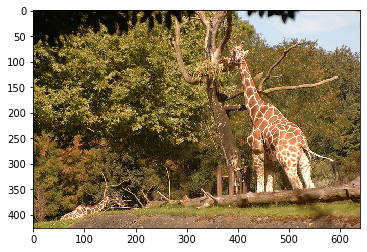

In [0]:
show_image(idx=1, train=True)

## Pre-Trained Image Model (VGG16)

The following creates an instance of the VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.

If `include_top=True` then the whole VGG16 model is downloaded which is about 528 MB. If `include_top=False` then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We will use some of the fully-connected layers in this pre-trained model, so we have to download the full model, but if you have a slow internet connection, then you can try and modify the code below to use the smaller pre-trained model without the classification layers.

Tutorials #08 and #10 explain more details about Transfer Learning.

In [0]:
image_model = InceptionResNetV2(include_top=True, weights='imagenet')

225214464/225209952 [==============================] - 3s 0us/step


Print a list of all the layers in the VGG16 model.

In [0]:
image_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

We will use the output of the layer prior to the final classification-layer which is named `fc2`. This is a fully-connected (or dense) layer.

In [0]:
transfer_layer = image_model.get_layer('avg_pool')

We call it the "transfer-layer" because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original VGG16 model but outputs the transfer-values from the `fc2` layer.

In [0]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The model expects input images to be of this size:

In [0]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(299, 299)

For each input image, the new model will output a vector of transfer-values with this length:

In [0]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

1536

### Process All Images

We now make functions for processing all images in the data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing the progress.

In [0]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [0]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [0]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Helper-function for processing all images in the validation-set.

In [0]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. This took about 30 minutes to process on a GTX 1070 GPU.

In [0]:
#don't do
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Progress: 100.0%
- Data saved to cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 1536)
CPU times: user 40min 27s, sys: 4min 53s, total: 45min 21s
Wall time: 48min 45s


Process all images in the validation-set and save the transfer-values to a cache-file. This took about 90 seconds to process on a GTX 1070 GPU.

In [0]:
#don't do
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Progress: 99.8%
- Data saved to cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 1536)
CPU times: user 1min 43s, sys: 13.7 s, total: 1min 56s
Wall time: 2min 2s


## Tokenizer

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer. See Tutorial #20 for a more detailed explanation.

Before we can start processing the text, we first need to mark the beginning and end of each text-sequence with unique words that most likely aren't present in the data.

In [0]:
mark_start = 'ssss '
mark_end = ' eeee'

This helper-function wraps all text-strings in the above markers. Note that the captions are a list of list, so we need a nested for-loop to process it. This can be done using so-called list-comprehension in Python.

In [0]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

Now process all the captions in the training-set and show an example.

In [0]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

This is how the captions look without the start- and end-markers.

In [0]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

This helper-function converts a list-of-list to a flattened list of captions.

In [0]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

Now use the function to convert all the marked captions from the training set.

In [0]:
captions_train_flat = flatten(captions_train_marked)

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 10000 most frequent words in the captions from the training-data.

In [0]:
num_words = 20000

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.

In [0]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Now create a tokenizer using all the captions in the training-data. Note that we use the flattened list of captions to create the tokenizer because it cannot take a list-of-lists.

In [0]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 10.3 s, sys: 5.38 ms, total: 10.3 s
Wall time: 10.3 s


Get the integer-token for the start-marker (the word "ssss"). We will need this further below.

In [0]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

Get the integer-token for the end-marker (the word "eeee").

In [0]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

Convert all the captions from the training-set to sequences of integer-tokens. We get a list-of-list as a result.

In [0]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 10.1 s, sys: 66.8 ms, total: 10.2 s
Wall time: 10.2 s


Example of the integer-tokens for the captions of the first image in the training-set:

In [0]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

These are the corresponding text-captions:

In [0]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

## Data Generator

Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [0]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

This generator function creates random batches of training-data for use in training the neural network.

In [0]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Set the batch-size used during training. This is set very high so the GPU can be used maximally - but this also requires a lot of RAM on the GPU. You may have to lower this number if the training runs out of memory.

In [0]:
batch_size = 512

Create an instance of the data-generator.

In [0]:
generator = batch_generator(batch_size=batch_size)

Test the data-generator by creating a batch of data.

In [0]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

Example of the transfer-values for the first image in the batch.

In [0]:
batch_x['transfer_values_input'][0]

array([9.351e-02, 4.004e-01, 1.052e-04, ..., 1.342e+00, 9.321e-01,
       1.815e-01], dtype=float16)

Example of the token-sequence for the first image in the batch. This is the input to the decoder-part of the neural network.

In [0]:
batch_x['decoder_input'][0]

array([   2,    1,   95,   46, 3397,  699,    4,    1,  110,  109,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

This is the token-sequence for the output of the decoder. Note how it is the same as the sequence above, except it is shifted one time-step.

In [0]:
batch_y['decoder_output'][0]

array([   1,   95,   46, 3397,  699,    4,    1,  110,  109,    3,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

### Steps Per Epoch

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an 'epoch' to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

This is the number of captions for each image in the training-set.

In [0]:
num_captions_train = [len(captions) for captions in captions_train]

This is the total number of captions in the training-set.

In [0]:
total_num_captions_train = np.sum(num_captions_train)

This is the approximate number of batches required per epoch, if we want to process each caption and image pair once per epoch.

In [0]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1155

## Create the Recurrent Neural Network

We will now create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be converted into text. We call this neural network for the 'decoder' as it is almost identical to the decoder when doing Machine Translation in Tutorial #21.

Note that we are using the functional model from Keras to build this neural network, because it allows more flexibility in how the neural network can be connected, in case you want to experiment and connect the image-model directly to the decoder (see the exercises). This means we have split the network construction into two parts: (1) Creation of all the layers that are not yet connected, and (2) a function that connects all these layers.

The decoder consists of 3 GRU layers whose internal state-sizes are:

In [0]:
state_size = 512

The embedding-layer converts integer-tokens into vectors of this length:

In [0]:
embedding_size = 128

This inputs transfer-values to the decoder:

In [0]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

We want to use the transfer-values to initialize the internal states of the GRU units. This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512, so we use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [0]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. Using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [0]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors.

In [0]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [0]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape `[batch_size, sequence_length, state_size]`, where each "word" is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is extremely wasteful, because for a vocabulary of e.g. 10000 words we need a vector with 10000 elements, so we can select the index of the highest element to be the integer-token.

Note that the activation-function is set to `linear` instead of `softmax` as we would normally use for one-hot encoded outputs, because there is apparently a bug in Keras so we need to make our own loss-function, as described in detail further below.

In [0]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

### Connect and Create the Training Model

The decoder is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to have multiple inputs. This is useful e.g. if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values.

This function connects all the layers of the decoder to some input of transfer-values.

In [0]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connect and create the model used for training. This takes as input transfer-values and sequences of integer-tokens and outputs sequences of one-hot encoded arrays that can be converted into integer-tokens.

In [0]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Loss Function

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in the `batch_generator()` above.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays. Unfortunately, there seems to be a bug in Keras when using this with Recurrent Neural Networks, so the following does not work:

In [0]:
#decoder_model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

The decoder outputs a 3-rank tensor with shape `[batch_size, sequence_length, num_words]` which contains batches of sequences of one-hot encoded arrays of length `num_words`. We will compare this to a 2-rank tensor with shape `[batch_size, sequence_length]` containing sequences of integer-tokens.

This comparison is done with a sparse-cross-entropy function directly from TensorFlow. There are several things to note here.

Firstly, the loss-function calculates the softmax internally to improve numerical accuracy - this is why we used a linear activation function in the last dense-layer of the decoder-network above.

Secondly, the loss-function from TensorFlow will output a 2-rank tensor of shape `[batch_size, sequence_length]` given these inputs. But this must ultimately be reduced to a single scalar-value whose gradient can be derived by TensorFlow so it can be optimized using gradient descent. Keras supports some weighting of loss-values across the batch but the semantics are unclear so to be sure that we calculate the loss-function across the entire batch and across the entire sequences, we manually calculate the loss average.

In [0]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile the Training Model

We have used the Adam optimizer in many of the previous tutorials, but it seems to diverge in some of these experiments with Recurrent Neural Networks. RMSprop seems to work much better for these.

In [0]:
optimizer = RMSprop(lr=1e-3)

There seems to be another bug in Keras so it cannot automatically deduce the correct shape of the decoder's output data. We therefore need to manually create a placeholder variable for the decoder's output. The shape is set to `(None, None)` which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [0]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

We can now compile the model using our custom loss-function.

In [0]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [0]:
#decoder_model.compile(optimizer=optimizer,
 #                     loss=sparse_cross_entropy,
 #                     metrics=['accuracy'])

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [0]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

This is the callback for writing the TensorBoard log during training.

In [0]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [0]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = '22_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

Now we will train the decoder so it can map transfer-values from the image-model to sequences of integer-tokens for the captions of the images.

One epoch of training took about 7 minutes on a GTX 1070 GPU. You probably need to run 20 epochs or more during training.

Note that if we didn't use pre-computed transfer-values then each epoch would take maybe 40 minutes to run, because all the images would have to be processed by the VGG16 model as well.

In [0]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=callbacks)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1154/1155 [============================>.] - ETA: 0s - loss: 1.4179
Epoch 00001: saving model to 22_checkpoint.keras
1155/1155 [==============================] - 369s 319ms/step - loss: 1.4178
Epoch 2/20
1154/1155 [============================>.] - ETA: 0s - loss: 1.0455
Epoch 00002: saving model to 22_checkpoint.keras
1155/1155 [==============================] - 358s 310ms/step - loss: 1.0452
Epoch 3/20
1154/1155 [============================>.] - ETA: 0s - loss: 0.9882
Epoch 00003: saving model to 22_checkpoint.keras
1155/1155 [==============================] - 357s 309ms/step - loss: 0.9883
Epoch 4/20
1154/1155 [============================>.] - ETA: 0s - loss: 0.9512
Epoch 00004: saving model to 22_checkpoint.keras
1155/1155 [==============================] - 360s 312ms/step - loss: 0.9512
Epoch 5/20
1154/1155 [============================>.] - ETA: 0s - loss: 0.9383
Epoch 00005

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

In [0]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    gen_cap=output_text
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()
    return gen_cap

In [0]:
decoder_model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
model=decoder_model

### Examples

Try this with a picture of a parrot.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


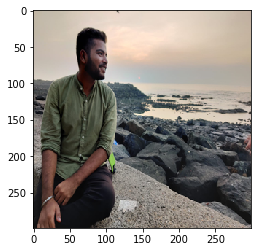

Predicted caption:
 a man and a woman are sitting on rocks looking at the ocean eeee



' a man and a woman are sitting on rocks looking at the ocean eeee'

In [0]:
generate_caption("/content/images/WhatsApp Image 2019-12-18 at 12.27.24 PM (1).jpeg")

Try it with a picture of a person (Elon Musk). In Tutorial #07 the Inception model mis-classified this picture as being either a sweatshirt or a cowboy boot.

In [0]:
generate_caption("images/elon_musk.jpg")

Helper-function for loading an image from the COCO data-set and printing the true captions as well as the predicted caption.

In [0]:
from nltk.translate.bleu_score import sentence_bleu
#from nltk.translate.bleu_score import corpus_bleu

def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    gen_cap=generate_caption(image_path=path)
    score = sentence_bleu(captions, gen_cap)
    #score = corpus_bleu(captions, gen_cap)
    print('Sentence BLEU: %f' % score)
    print('Individual 1-gram: %f' % sentence_bleu(captions, gen_cap, weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(captions, gen_cap, weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(captions, gen_cap, weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(captions, gen_cap, weights=(0, 0, 0, 1)))
    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

Try this on a picture from the training-set that the model has been trained on. In some cases the generated caption is actually better than the human-generated captions.

In [0]:
decoder_model

In [0]:
generate_caption_coco(idx=1, train=True)

Here is another picture of giraffes from the training-set, so this image was also used during training of the model. But the model can't produce an accurate caption. Perhaps it needs more training, or perhaps another architecture for the Recurrent Neural Network?

In [0]:
generate_caption_coco(idx=10, train=True)

Here is a picture from the validation-set which was not used during training of the model. Sometimes the model can produce good captions for images it hasn't seen during training and sometimes it can't. Can you make a better model?

In [0]:
generate_caption_coco(idx=844, train=False)

## Conclusion

This tutorial showed how to generate captions for images. We used a pre-trained image-model (VGG16) to generate a "thought-vector" of what the image contains, and then we trained a Recurrent Neural Network to map this "thought-vector" to a sequence of words.

This works reasonably well, although it is easy to find examples both in the training- and validation-sets where the captions are incorrect.

It is also important to understand that this model doesn't have a human-like understanding of what the images contain. If it sees an image of a giraffe and correctly produces a caption stating that, it doesn't mean that the model has a deep understanding of what a giraffe is; the model doesn't know that it's a tall animal that lives in Africa and Zoos.

The model is merely a clever way of mapping pixels in an image to a vector of floating-point numbers that summarize the contents of the image, and then map these numbers to a sequence of integers-tokens representing words. So the model is basically just a very advanced function approximator rather than human-like intelligence.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Train the model for more epochs. Does it improve the quality of the generated captions?
* Try another architecture for the Recurrent Neural Network, e.g. change the number of GRU layers, their internal state-size, the embedding-size, etc. Can you improve the quality of the generated captions?
* Use another transfer-layer from the VGG16-model, for example the flattened output of the last convolutional layer.
* Try adding more dense-layers to the mapping between the transfer-values and the initial-state in the decoder.
* When generating captions, instead of using `np.argmax()` to sample the next integer-token, could you sample the decoder's output as if it was a probability distribution instead? Note that the decoder's output is not softmax-limited so you have to do that first to turn it into a probability-distribution.
* Can you generate multiple sequences by doing this sampling? Can you find a way to select the best of these different sequences?
* Connect the image-model directly to the decoder so you can fine-tune the weights of the image-model. See Tutorial #10 on Fine-Tuning.
* Can you train a Machine Translation model from Tutorial #21 and then connect its decoder to a pre-trained image-model to make an image captioning model? Perhaps you need an intermediate fully-connected layer that you will train.
* Can you measure the quality of the generated captions using some mathematical formula?
* Modify the decoder so it also returns the states of the GRU-units. Then change `generate_caption()` so it only inputs and outputs one integer-token in each iteration. You need to get the GRU-states out of `decoder_model.predict()` and feed them back in next time you call it. Now you compute less in each iteration, but there is still a lot of overhead, so it may not be much faster when using a GPU?
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.